In [1]:
# Loading Dependencies

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# SciKit Learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import MDS, Isomap, TSNE
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Viz
import seaborn as sns
%matplotlib inline

# Introduction  

# Reading in Data

In [2]:
# From http://archive.ics.uci.edu/ml/datasets/Heart+Disease
# http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names


# Using the American data sets within these - the data from Cleveland and from Long Beach 
heart_df_cl = pd.read_csv("../data/processed.cleveland.data.txt", header = None)
#heart_df_lb = pd.read_csv("../data/processed.va.data.txt", header = None)
#heart_df_h = pd.read_csv("../data/processed.hungarian.data.txt", header = None)
#heart_df_sw = pd.read_csv("../data/processed.switzerland.data.txt", header = None)

#heart_df = heart_df_cl.append(heart_df_lb).append(heart_df_h).append(heart_df_sw)
    
heart_df = heart_df_cl
# More interpretable names taken from dataset description above
var_names = ["age", "sex", "chest_pain", "rest_bp", "chol", "bld_gluc",\
             "ecg_st_e","strs_max_hr", "ex_ang", "ecg_st_d_exer", "ecg_st_slope",\
            "cor_a", "strs_test", "diagnosis"]

heart_df.columns = var_names

In [3]:
# Pre-Wrangled Data
print("Observations: {}".format(heart_df.shape[0]))
print("Features: {}".format(heart_df.shape[1]))

Observations: 303
Features: 14


### Understanding the Predictors 

**Continuous Predictors**    
`age`: Age  
`rest_bp`: Resting Blood Pressure on Admission  
`chol`: Serum Cholesterol Level (mg/dL)  
`strs_max_hr`: Maximum Heart Rate achieved during Stress Testing  
`ecg_st_d_exer`: ST depression induced by exercise relative to rest  

**Categorical Predictors**    
`sex`: Male or Female  
`chest_pain`: Classified into 4 types of chest pain (where 1 is most highly correlated with cardiovascular) - therefore will need to be changed with dummy variables.   
        -- Value 1: typical angina  
        -- Value 2: atypical angina  
        -- Value 3: non-anginal pain  
        -- Value 4: asymptomatic  
`bld_gluc`: Yes or No to whether the blood glucose is high (above 120mg/dL - i.e. 6.7 mmol/L)  
`ecg_st_e`: ST Elevation on ECG at Rest. Value 1 means ST Elevation (highly indicative of coronary artery involvement), whereas value 2 is indicative of Left Ventricular Hypertrophy (which is less indicative but important). 
`ex_ang`: Yes or no to exercise-induced angina (chest pain caused from exercise)   
`ecg_st_slope`: upsloping, downsloping, or flat ST segment during exercise  
`cor_a`: Coronary artery vessels coloured by fluoroscopy (number of vessels from 0-3).   
`strs_test`: Result of nuclear stress testing - only 3 levels. Where 6 means a fixed defect, 7 means a reversible defect, and 3 means normal.    


Since some of these categorical predictors have more than 2 levels they will need to be altered as dummy variables. These include: `chest_pain`, `ecg_st_e`, `cor_a`, `strs_test`.  


In [4]:
# Drop all observations with NAs
heart_df = heart_df.replace("?", np.nan)
heart_df = heart_df.dropna()

Note: by Dropping NAs, I am introducing bias. It is possible that patients in higher acuity (i.e. sicker) will have had less opportunity to get all the testing before angiography -- therefore those that have no NAs are actually less likely to have a positive prediction (which denotes >50% occlusion on angiography. I understand this flaw, but for the purposes of this analysis I will only be looking at modeling those who are low acuity enough to have complete data, and with this additional constraint, I can then drop the NAs and will treat them as being missing completely at random.  

This is less an issue when I am just looking at the cleveland data, because it is much more complete. The data from Hungary, Switzerland and Long Beach have much more NAs with regards to Stress Testing (`strs_test`, `ect_st_slope` - and this may make sense, these are expensive tests that you can't do on people who are high acuity (if someone is actively having a heart attack it's a bad idea to inject them with nucleotides and get them to run on a treadmill. 

In [5]:
# Set Predictor (Diagnosis) to 0 or 1, where 1 means >50% artery narrowing on angiography
heart_df.diagnosis = [1 if x > 0 else x for x in heart_df.diagnosis]

# Dataframe for later reference in visualization
heart_df_original = heart_df

# Convert the `chest_pain` 4 level categorical variable into 4 binary features
heart_df = pd.get_dummies(heart_df, columns = ["chest_pain"])

# Convert the `ecg_st_e` 3 level categorical variable into 3 binary features
heart_df = pd.get_dummies(heart_df, columns = ["ecg_st_e"])

# Convert the `cor_a` 4 level categorical variable into 4 binary features
heart_df = pd.get_dummies(heart_df, columns = ["cor_a"])

# Convert the `ecg_st_slope` 3 level categorical variable into 3 binary features
heart_df = pd.get_dummies(heart_df, columns = ["ecg_st_slope"])

# Convert the `strs_test` 3 level categorical variable into 3 binary features
heart_df = pd.get_dummies(heart_df, columns = ["strs_test"])


In [6]:
heart_df.head()

,age,sex,rest_bp,chol,bld_gluc,strs_max_hr,ex_ang,ecg_st_d_exer,diagnosis,chest_pain_1.0,...,cor_a_0.0,cor_a_1.0,cor_a_2.0,cor_a_3.0,ecg_st_slope_1.0,ecg_st_slope_2.0,ecg_st_slope_3.0,strs_test_3.0,strs_test_6.0,strs_test_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0,1,...,1,0,0,0,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,1,0,...,0,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,1,0,...,0,0,1,0,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0,0,...,1,0,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0,0,...,1,0,0,0,1,0,0,1,0,0


In [7]:
# After-Wrangled Data
print("Observations: {}".format(heart_df.shape[0]))
print("Features: {}, with {} Response Variable".format(heart_df.shape[1]-1, 1))

Observations: 297
Features: 25, with 1 Response Variable


In [8]:
# Get into matrix states for next phase

X = np.array(heart_df.drop(["diagnosis"], axis = 1))
y = np.array(heart_df.diagnosis)


In [9]:
# Additionally, I want to scale the continuous variables to be between 0 and 1, so that they don't overpower
# the categorical variables

scale_0_1 = MinMaxScaler((0,1))

X = scale_0_1.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state = 123)

# Exploratory Data Analysis 

**Figure**

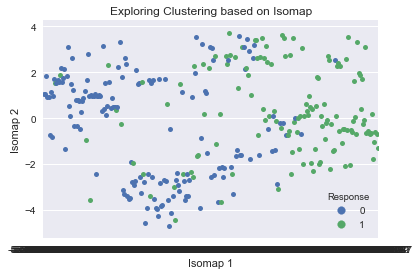

In [11]:
isomap = Isomap(n_components=2)
Z_isomap = isomap.fit_transform(X)
Z_df = pd.DataFrame(Z_isomap)
Z_df.columns = ["Isomap 1", "Isomap 2"]
Z_df["Response"] = y

sns.stripplot(x = "Isomap 1", y = "Isomap 2", hue = "Response", data = Z_df)
plt.title("Exploring Clustering based on Isomap")

Based on this Isomap vis there does appear to be significant differences between the negative and positive responses, which is encouraging that a model will be able to separate the two. 

**Table**

In [12]:
# Subset dataframes into those that resulted in >50% occlusion of coronary arteries on angiography and those that didn't
heart_df_positive = heart_df.loc[heart_df["diagnosis"] == 1,:].drop(["diagnosis"], axis = 1)
heart_df_negative = heart_df.loc[heart_df["diagnosis"] == 0,:].drop(["diagnosis"], axis = 1)

# Get summary statistics for all the features in each dataframe
heart_pos_describe = heart_df_positive.describe().loc[["mean", "min","max", "50%"],:]
heart_neg_describe = heart_df_negative.describe().loc[["mean", "min","max", "50%"],:]

In [13]:
# Return the Difference between each data frame summary statistics 
## Where positive numbers means more in the with coronary's blocked category (positive)
heart_diff = (heart_pos_describe - heart_neg_describe).T
heart_diff

,mean,min,max,50%
age,4.115374,6.0,1.0,6.0
sex,0.261268,0.0,0.0,0.0
rest_bp,5.460036,6.0,20.0,0.0
chol,8.360265,5.0,-155.0,17.5
bld_gluc,0.002235,0.0,0.0,0.0
strs_max_hr,-19.471761,-25.0,-7.0,-19.0
ex_ang,0.396396,0.0,0.0,1.0
ecg_st_d_exer,0.990301,0.0,2.0,1.2
chest_pain_1.0,-0.048905,0.0,0.0,0.0
chest_pain_2.0,-0.184307,0.0,0.0,0.0


**Table Discussion:**  
Here I've kept together the continuous and the categorical features. Since all the categorical features are dummy variables, we can take a positive number to mean this feature is present more often in among the coronary disease 'positive' than the 'negative' (as determined by angiography).  

Age, Sex, Resting Blood Pressure, and Cholesterol are all continuous variables that respond as I would expect - those with coronary artery (CA) disease will have higher for all of them because they are heart disease risk factors. As well, you would expect those without heart disease to be able to hit a higher max stress test (although this is a bit more variable. 

As for the categorical variables, to take a few examples it makes sense that `ex_ang` (exercise induced angina), Positive Stress test findings (`strs_test_6.0`, `strs_test_7.0`) and rest ECG ST segment findings (`ecg_st_slope_1.0` corresponding to ST elevation and `ecg_st_slope_2.0`) would be positive because they are more likely in patients with CA disease. Likewise Normal rest ECG (`ecg_st_slope_0.0`) and Normal Stress test (`ecg_test_3.0`) are both negative as I'd expect.  

Some surprising relationships: even though every medical student knows that ST elevation means 'badness', there is only a very small difference between positive and negative CA disease for `ecg_st_e_1.0` of 0.015648 although I would have expected much higher - perhaps there are a lot of false positives among the non CA disease group. 

I also found it surprising that typical chest pain `chest_pain_1.0` (what you think of when you hear of someone having a heart attack) was actually more likely among those without CA disease, and asymptomatic `chest_pain_4.0` was most associated with CA disease. My hypothesis for this is that this dataset is *not high acuity*. The people who present to the emergency with a heart attack wouldn't have gotten the stress test like everyone in the above dataset has gotten. Therefore we should be thinking about this dataset as being the subpopulation of people with heart disease that are stable enough to get outpatient stress testing - this subpopulation may very well have more asymptomatic presentations.  

# Feature Selection

In [14]:
# First let's look at what plain logistic regression yields
## Here I set the penalty to L2 and set the C arbitrarily large so that there is effectively no penalty
log_model = LogisticRegression(penalty = "l1", C = 10000)
log_model.fit(X_train, y_train)

log_train = 1 - log_model.score(X_train, y_train)
log_test = 1 - log_model.score(X_test, y_test)

print("The Training Error is:", log_train)
print("The Testing Error is:", log_test)

The Training Error is: 0.126582278481
The Testing Error is: 0.116666666667


### L1 Regularization for Feature Selection

In [15]:
# Cross Validation for the strength of L1 Regularization parameter C
C_s = np.arange(0.05,10,0.05)
lasso = LogisticRegressionCV(Cs = C_s, penalty = "l1", solver = "liblinear", cv = 5)
lasso.fit(X_train,y_train)

LogisticRegressionCV(Cs=array([ 0.05,  0.1 , ...,  9.9 ,  9.95]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)

In [16]:
print("The Training Error is:", 1 - lasso.score(X_train,y_train))
print("The Testing Error is:", 1 - lasso.score(X_test, y_test))
print("Using a regularization parameter of {}".format(lasso.C_[0]))

The Training Error is: 0.160337552743
The Testing Error is: 0.116666666667
Using a regularization parameter of 0.1


In [17]:
l1_var_excluded = np.array(heart_df_positive.columns)[(lasso.coef_ == 0).flatten()]
l1_var_included = np.array(heart_df_positive.columns)[(lasso.coef_ != 0).flatten()]
print("This means L1 Regularization would remove {} variables: \n {}".format(len(l1_var_excluded), l1_var_excluded))
print("\n", "\n")
print("This means only keeping {} variables:{}".format(len(l1_var_included), l1_var_included))

This means L1 Regularization would remove 19 variables: 
 ['age' 'sex' 'rest_bp' 'chol' 'bld_gluc' 'strs_max_hr' 'ecg_st_d_exer'
 'chest_pain_1.0' 'chest_pain_2.0' 'chest_pain_3.0' 'ecg_st_e_0.0'
 'ecg_st_e_1.0' 'ecg_st_e_2.0' 'cor_a_1.0' 'cor_a_2.0' 'cor_a_3.0'
 'ecg_st_slope_2.0' 'ecg_st_slope_3.0' 'strs_test_6.0']

 

This means only keeping 6 variables:['ex_ang' 'chest_pain_4.0' 'cor_a_0.0' 'ecg_st_slope_1.0' 'strs_test_3.0'
 'strs_test_7.0']


**Backward Selection**

In [18]:
# Since we aren't using Cross Validation

In [19]:
n_features_left = np.arange(6,24,1)
back_select = RFE(LogisticRegression(penalty="l2", C = 10000))
n_features_dict = {"n_features_to_select":n_features_left}

rfe_grid = GridSearchCV(back_select, n_features_dict)
rfe_grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RFE(estimator=LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=None, step=1, verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_features_to_select': array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [20]:
print("The Training Error is:", 1 - rfe_grid.score(X_train,y_train))
print("The Testing Error is:", 1 - rfe_grid.score(X_test, y_test))

rfe_var_excluded = np.array(heart_df_positive.columns)[rfe_grid.best_estimator_.support_ != True]

rfe_var_included = np.array(heart_df_positive.columns)[rfe_grid.best_estimator_.support_]


print("After Cross-Validation for number of features to remain: \n \n ")

print("There are {} features EXCLUDED, which include \n {} \n \n".format(len(rfe_var_excluded), rfe_var_excluded))

print("There are {} features SELECTED, which include \n {}".format(len(rfe_var_included), rfe_var_included))

The Training Error is: 0.126582278481
The Testing Error is: 0.116666666667
After Cross-Validation for number of features to remain: 
 
 
There are 7 features EXCLUDED, which include 
 ['ecg_st_e_1.0' 'ecg_st_e_2.0' 'cor_a_1.0' 'ecg_st_slope_2.0'
 'ecg_st_slope_3.0' 'strs_test_3.0' 'strs_test_6.0'] 
 

There are 18 features SELECTED, which include 
 ['age' 'sex' 'rest_bp' 'chol' 'bld_gluc' 'strs_max_hr' 'ex_ang'
 'ecg_st_d_exer' 'chest_pain_1.0' 'chest_pain_2.0' 'chest_pain_3.0'
 'chest_pain_4.0' 'ecg_st_e_0.0' 'cor_a_0.0' 'cor_a_2.0' 'cor_a_3.0'
 'ecg_st_slope_1.0' 'strs_test_7.0']


In [21]:
# Let's combine the results from L1 Regularization and RFE
intersect_excluded = np.intersect1d(rfe_var_excluded, l1_var_excluded)
intersect_included = np.intersect1d(rfe_var_included, l1_var_included)

print("There were {} Features Excluded by BOTH methods: \n {}\n\n".format(len(intersect_excluded), intersect_excluded))

print("There were {} Features Included by BOTH methods: \n {}\n\n".format(len(intersect_included), intersect_included))


There were 6 Features Excluded by BOTH methods: 
 ['cor_a_1.0' 'ecg_st_e_1.0' 'ecg_st_e_2.0' 'ecg_st_slope_2.0'
 'ecg_st_slope_3.0' 'strs_test_6.0']


There were 5 Features Included by BOTH methods: 
 ['chest_pain_4.0' 'cor_a_0.0' 'ecg_st_slope_1.0' 'ex_ang' 'strs_test_7.0']




In [24]:
l1_exclude_positions= np.nonzero(lasso.coef_ == 0)[1]
rfe_exclude_positions = np.nonzero(rfe_grid.best_estimator_.support_ != True)[0]

new_exclude = np.intersect1d(l1_exclude_positions, rfe_exclude_positions)

In [25]:
features_to_include = np.setdiff1d(np.arange(0, len(heart_df_positive.columns)), new_exclude)

In [26]:
X = X[:, features_to_include]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state = 123)

| Feature Selection Method | Training Error | Testing Error | Features Excluded | Features Included |
| ---------------- | ------ | ------- | ------- | -------- |
| Plain Logistic Regression | 0.12658 | 0.11667 | 0 | 25 |
| L1 Regularization | 0.16033 | 0.11667 | 19 | 6 |
| Recursive Feature Elimination | 0.12658 | 0.11667 | 7 | 18 |
| Intersection of Both Methods | -- | -- | 6 | 5 |


**Discussion of Feature Selection**  

Firstly, the dataset that I'm using contains only 14 features of a greater 76 features. The problem is that the dataset that I've chosen has already gone through feature selection - so this makes feature selection for me much more challenging to see actual improvements with feature reduction.  

Even with L1 regularization (after cross validation to select the optimal regularization parameter) the resulting test error does not actually improve compared to a model with the full feature set - but that being said it is able to achieve the same test error on logistic regression as the full feature model. Likewise Recursive Feature Elimination (after cross validation to select how many features should be elimiated) did not improve or worsen overall test error. 

Therefore, I chose to look at the feature excluded in *both* models and decided to remove these features when I select the model.

These 6 features are:   
'cor_a_1.0' - Having exactly 1 Coronary artery vessel coloured by fluoroscopy.  
'ecg_st_e_1.0' - ST Elevation on ECG indicative of coronary artery involvement  
'ecg_st_e_2.0' - ST Segment chagnes indicating Left Ventricular Hypertrophy  
'ecg_st_slope_2.0' - ST Slope downsloping  
'ecg_st_slope_3.0' - ST Slope flat  
'strs_test_6.0' - ST Fixed defect  

Medically speaking, some of this is surprising. Particularly the 'ecg_st_e_1.0' ST elevation finding which is a well known diagnostic criteria.  

This is likely because this specific data represents patients who were able to have stress tests (i.e. they're not sick enough that they can't run on a treadmill). This means these weren't the type of patients who are coming into the emergency department with acute chest pain. This data more captures patients seen with longer term chest pain seen as outpatients. In this case it may be more reasonable to remove some of these. 

# Model Selection

### Random Forests

In [27]:
rand_forest = RandomForestClassifier()

n_estimator = np.arange(3,40,2)
max_depth = np.arange(1,10,2)

rand_param = {"n_estimators":n_estimator, 
             "max_depth":max_depth}

rand_grid = GridSearchCV(rand_forest, rand_param)
rand_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39]), 'max_depth': array([1, 3, 5, 7, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [28]:
rand_grid.best_params_

{'max_depth': 1, 'n_estimators': 19}

In [29]:
print("The Training Error is:", 1 - rand_grid.score(X_train,y_train))
print("The Testing Error is:", 1 - rand_grid.score(X_test, y_test))
print("Using a decision stumps of {} and {} trees".format(rand_grid.best_params_["max_depth"], rand_grid.best_params_["n_estimators"]))

The Training Error is: 0.172995780591
The Testing Error is: 0.116666666667
Using a decision stumps of 1 and 19 trees


### KNN

In [30]:
knn = KNeighborsClassifier()

n_neighbors = np.arange(1,20,1)

knn_param = {"n_neighbors":n_neighbors}

knn_grid = GridSearchCV(knn, knn_param)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [31]:
print("The Training Error is:", 1 - knn_grid.score(X_train,y_train))
print("The Testing Error is:", 1 - knn_grid.score(X_test, y_test))
print("Using {} Nearest Neighbors".format(knn_grid.best_params_["n_neighbors"]))

The Training Error is: 0.147679324895
The Testing Error is: 0.15
Using 17 Nearest Neighbors


### SVM

In [32]:
gammas = [10**-(float(x)) for x in range(6,-1,-1)]
C = gammas

In [33]:
svm = SVC()
svm_param = {"gamma": gammas, 
            "C": C}

svm_grid = GridSearchCV(svm, svm_param)
svm_grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0], 'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [34]:
svm_grid.best_params_

{'C': 1.0, 'gamma': 0.01}

In [35]:
1 - svm_grid.score(X_test,y_test)
print("The Training Error is:", 1 - svm_grid.score(X_train,y_train))
print("The Testing Error is:", 1 - svm_grid.score(X_test,y_test))
print("Using C: {}, gamma: {}".format(svm_grid.best_params_["C"], svm_grid.best_params_["gamma"]))

The Training Error is: 0.147679324895
The Testing Error is: 0.166666666667
Using C: 1.0, gamma: 0.01


In [40]:
log_reg = LogisticRegression(penalty = "l1", C = 0.1)
log_reg.fit(X_train,y_train)

print("The Training Error is:", 1 - log_reg.score(X_train,y_train))
print("The Testing Error is:", 1 - log_reg.score(X_test,y_test))
print("Using C: {}".format(0.1))

The Training Error is: 0.160337552743
The Testing Error is: 0.116666666667
Using C: 0.1


In [47]:
print("There were {} Features that were Non-Zero: \n {} \n".format(len(np.nonzero(log_reg.coef_)[1]), np.nonzero(log_reg.coef_)[1]))

There were 6 Features that were Non-Zero: 
 [ 6 11 13 16 17 18] 



| | Training Error | Testing Error |
| ----- | ------------ | ------------- |
| Random Forest | 0.17300 | 0.15 |
| KNN | 0.14768 | 0.15 |
| SVM | 0.14768 | 0.16667 | 
| Logistic Regression | 0.16033 | 0.11666 |

## Discussion

Why did this happen? In the feature selection step, we couldn't improve the basic logistic regression model even when we removed features, and then in the model selection step, all our models were actually *worse* than the CV L1 regularized logistic regression model. What gives?  

I think I learned a few lessons with this analysis. 

Firstly, these results are a consequence of using a dataset that has already undergone feature selection. As I mentioned above there are 14 features in this dataset out of a greater 76 original features. When I decided to reduce these features further, in every step I used cross-validation (and thus didn't report the validation error, but rather the training error of the model that was selected by cross-validation). As mentioned in the previous section, each feature selection step didn't actually improve the overall test error (and note - I kept the test set separate during cross-validation to avoid overfitting). With this in mind, it is not overly surprising that the model selection phase didn't work very well. 

When we did make it to model selection, the best test error we could get was with logistic regression that only kept 6 features (after L1 regularization) and returned the same test error as the *original logistic regression model with all features and without regularization*. This is because the dataset I was using had already been feature selected for logistic regression before I even began. Unfortunately, despite further subsetting features and trying out different models, I was still unable to reduce the test error that I started with. 

While I was feature selecting (and although I was cross-validating and not tuning hyperparameters on the test set which I know is a big no-no), I did look at the result in the context of how it performed on test data at each step. When I was feature selecting and cross-validating for L1 regularization and backward selection, both of these steps used Logistic Regression as a base estimator, and thus I feature selected in such a way as to minimize error in logistic regression. Perhaps, I should have feature selected with different estimators in my cross-validation (for instance using KNN in the backward selection) and I would have gotten features that would work better in KNN.  

Additional future directions could include trying additional ensemble methods than Random Forest, such as bagging, to see if I can improve the overall model. 